In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser
import glob

In [2]:
PROTEIN_APPEARS_IN_REPLICATES = 5

In [3]:
PROTON_MASS = 1.00727647
ADD_C_CYSTEINE_DA = 57.021464

In [4]:
# calculate the monoisotopic mass    
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [5]:
EXPERIMENT_DIR = '/media/big-ssd/experiments'
UPS1_EXPERIMENT_DIR = '{}/P3830_YUPS1'.format(EXPERIMENT_DIR)
UPS2_EXPERIMENT_DIR = '{}/P3830_YUPS2'.format(EXPERIMENT_DIR)

UPS1_MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-mq'.format(UPS1_EXPERIMENT_DIR)
UPS2_MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-mq'.format(UPS2_EXPERIMENT_DIR)

UPS1_PERCOLATOR_STDOUT_FILE_NAME = '{}/percolator-stdout.log'.format(UPS1_MQ_PERCOLATOR_OUTPUT_DIR)
UPS2_PERCOLATOR_STDOUT_FILE_NAME = '{}/percolator-stdout.log'.format(UPS2_MQ_PERCOLATOR_OUTPUT_DIR)

UPS1_MQ_FEATURES_DIR = '{}/features-mq'.format(UPS1_EXPERIMENT_DIR)
UPS2_MQ_FEATURES_DIR = '{}/features-mq'.format(UPS2_EXPERIMENT_DIR)

In [6]:
MAXIMUM_Q_VALUE = 0.01

#### analyse YUPS2

In [7]:
# load the percolator output
UPS2_MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/P3830_YUPS2.percolator.target.psms.txt".format(UPS2_MQ_PERCOLATOR_OUTPUT_DIR)

In [8]:
ups2_mq_psms_df = pd.read_csv(UPS2_MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
ups2_mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
ups2_mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
ups2_mq_psms_df = ups2_mq_psms_df[ups2_mq_psms_df['peptide mass'] > 0]

In [9]:
# determine the mapping between the percolator index and the run file name - this is only available by parsing percolator's stdout redirected to a text file.
mapping = []
with open(UPS2_PERCOLATOR_STDOUT_FILE_NAME) as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('INFO: Assigning index'):
            splits = line.split(' ')
            percolator_index = int(splits[3])
            comet_filename = splits[5]
            rn = comet_filename.split('/')[-1].split('.')[0]  # e.g. 190719_Hela_Ecoli_1to3_06
            short_run_name = '_'.join(rn.split('_Slot')[0].split('_')[1:])
            mapping.append((percolator_index, rn, short_run_name))
ups2_mapping_df = pd.DataFrame(mapping, columns=['file_idx','run_name','short_run_name'])

In [10]:
ups2_mapping_df

,file_idx,run_name,short_run_name
0,0,P3830_YeastUPS2_08_Slot1-1_1_5089,YeastUPS2_08
1,1,P3830_YeastUPS2_03_Slot1-1_1_5084,YeastUPS2_03
2,2,P3830_YeastUPS2_10_Slot1-1_1_5091,YeastUPS2_10
3,3,P3830_YeastUPS2_04_Slot1-1_1_5085,YeastUPS2_04
4,4,P3830_YeastUPS2_01_Slot1-1_1_5082,YeastUPS2_01
5,5,P3830_YeastUPS2_02_Slot1-1_1_5083,YeastUPS2_02
6,6,P3830_YeastUPS2_05_Slot1-1_1_5086,YeastUPS2_05
7,7,P3830_YeastUPS2_09_Slot1-1_1_5090,YeastUPS2_09
8,8,P3830_YeastUPS2_07_Slot1-1_1_5088,YeastUPS2_07
9,9,P3830_YeastUPS2_06_Slot1-1_1_5087,YeastUPS2_06


In [11]:
# add the run names
ups2_mq_percolator_df = pd.merge(ups2_mq_psms_df, ups2_mapping_df, how='left', left_on=['file_idx'], right_on=['file_idx'])

In [12]:
ups2_mq_percolator_df.run_name.unique()

array(['P3830_YeastUPS2_08_Slot1-1_1_5089',
       'P3830_YeastUPS2_03_Slot1-1_1_5084',
       'P3830_YeastUPS2_10_Slot1-1_1_5091',
       'P3830_YeastUPS2_04_Slot1-1_1_5085',
       'P3830_YeastUPS2_01_Slot1-1_1_5082',
       'P3830_YeastUPS2_02_Slot1-1_1_5083',
       'P3830_YeastUPS2_05_Slot1-1_1_5086',
       'P3830_YeastUPS2_09_Slot1-1_1_5090',
       'P3830_YeastUPS2_07_Slot1-1_1_5088',
       'P3830_YeastUPS2_06_Slot1-1_1_5087'], dtype=object)

In [13]:
# merge the precolator results with the MQ features - obtained with the APL-to-MGF converter (generate-MGF-from-MaxQuant-APLs.py)
mq_features_l = glob.glob('{}/exp-P3830_YUPS?-run-*-features-mq.pkl'.format(UPS2_MQ_FEATURES_DIR))
df_l = []
for f in mq_features_l:
    df = pd.read_pickle(f)
    df_l.append(df['features_df'])
ups2_mq_features_df = pd.concat(df_l, axis=0, sort=False, ignore_index=True)

In [14]:
ups2_mq_identifications_df = pd.merge(ups2_mq_features_df, ups2_mq_percolator_df, how='left', left_on=['raw_file','mq_index'], right_on=['run_name','mq_index'])
# remove any features that were not identified
ups2_mq_identifications_df.dropna(subset=['sequence'], inplace=True)

ups2_mq_identifications_df['short_run_name'] = ups2_mq_identifications_df.apply(lambda row: '_'.join(row.run_name.split('_Slot')[0].split('_')[1:]), axis=1)
ups2_mq_identifications_df['protein id'] = ups2_mq_identifications_df.apply(lambda row: row['protein id'].split(',')[0], axis=1)

In [15]:
ups2_mq_identifications_df['theoretical_peptide_mass'] = ups2_mq_identifications_df['peptide mass'] + (ups2_mq_identifications_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
ups2_mq_identifications_df['mass_accuracy_ppm'] = (ups2_mq_identifications_df['monoisotopic_mass'] - ups2_mq_identifications_df['theoretical_peptide_mass']) / ups2_mq_identifications_df['theoretical_peptide_mass'] * 10**6
ups2_mq_identifications_df['mass_error'] = ups2_mq_identifications_df['monoisotopic_mass'] - ups2_mq_identifications_df['theoretical_peptide_mass']


In [16]:
ups2_mq_identifications_df = ups2_mq_identifications_df[(ups2_mq_identifications_df['percolator q-value'] <= MAXIMUM_Q_VALUE) & (~ups2_mq_identifications_df['protein id'].str.contains('YEAST'))]

In [17]:
print('number of unique proteins: {}'.format(len(ups2_mq_identifications_df['protein id'].unique())))

number of unique proteins: 22


#### using the Top3 approach to determine protein quanitification

In [18]:
ups2_proteins_l = []

ups2_proteins_l.append({'uniprot':'P00915', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P00918', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P01031', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P69905', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P68871', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P41159', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P02768', 'fmoles':50000})
ups2_proteins_l.append({'uniprot':'P62988', 'fmoles':50000})

ups2_proteins_l.append({'uniprot':'P04040', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P00167', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P01133', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P02144', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P15559', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P62937', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'Q06830', 'fmoles':5000})
ups2_proteins_l.append({'uniprot':'P63165', 'fmoles':5000})

ups2_proteins_l.append({'uniprot':'P00709', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P06732', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P12081', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P61626', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'Q15843', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P02753', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P16083', 'fmoles':500})
ups2_proteins_l.append({'uniprot':'P63279', 'fmoles':500})

ups2_proteins_l.append({'uniprot':'P01008', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P61769', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P55957', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'O76070', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P08263', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P01344', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P01127', 'fmoles':50})
ups2_proteins_l.append({'uniprot':'P10599', 'fmoles':50})

ups2_proteins_l.append({'uniprot':'P99999', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P06396', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P09211', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P01112', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P01579', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P02787', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'O00762', 'fmoles':5})
ups2_proteins_l.append({'uniprot':'P51965', 'fmoles':5})

ups2_proteins_l.append({'uniprot':'P08758', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P02741', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P05413', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P10145', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P02788', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P10636-8', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P00441', 'fmoles':0.5})
ups2_proteins_l.append({'uniprot':'P01375', 'fmoles':0.5})

ups2_d = {}
for p in ups2_proteins_l:
    ups2_d[p['uniprot']] = p['fmoles']

In [19]:
ups2_mq_identifications_df['protein id'].unique()

array(['P02768ups|ALBU_HUMAN_UPS', 'P00918ups|CAH2_HUMAN_UPS',
       'P00915ups|CAH1_HUMAN_UPS', 'P62988ups|UBIQ_HUMAN_UPS',
       'P15559ups|NQO1_HUMAN_UPS', 'P68871ups|HBB_HUMAN_UPS',
       'P41159ups|LEP_HUMAN_UPS', 'P63165ups|SUMO1_HUMAN_UPS',
       'P04040ups|CATA_HUMAN_UPS', 'P02144ups|MYG_HUMAN_UPS',
       'P00167ups|CYB5_HUMAN_UPS', 'P69905ups|HBA_HUMAN_UPS',
       'P01031ups|CO5_HUMAN_UPS', 'P12081ups|SYHC_HUMAN_UPS',
       'Q06830ups|PRDX1_HUMAN_UPS', 'P00709ups|LALBA_HUMAN_UPS',
       'Q15843ups|NEDD8_HUMAN_UPS', 'P62937ups|PPIA_HUMAN_UPS',
       'P01133ups|EGF_HUMAN_UPS', 'P06732ups|KCRM_HUMAN_UPS',
       'P16083ups|NQO2_HUMAN_UPS', 'P02753ups|RETBP_HUMAN_UPS'],
      dtype=object)

In [20]:
# find the three most intense peptides for each protein
top3_l = []
for group_name,group_df in ups2_mq_identifications_df.groupby(['short_run_name','protein id']):
    short_run_name = group_name[0]
    protein_name = group_name[1]
    df = group_df.sort_values(by=['intensity'], ascending=False, inplace=False)
    top3_df = df.head(n=3)
    if len(top3_df) == 3:
        uniprot_id = protein_name.split('ups')[0]
        pmoles = ups2_d[uniprot_id] / 1000
        average_intensity = top3_df.intensity.mean()
        signal_response_factor = average_intensity / pmoles
        peptide_count = len(df)
        attribs_d = top3_df[['mq_index','sequence','charge','intensity']].to_dict('records')
        top3_l.append({'short_run_name':short_run_name, 'protein':protein_name, 'pmoles':pmoles, 'average_intensity':average_intensity, 'signal_response_factor':signal_response_factor, 'peptide_count':peptide_count, 'attribs_d':attribs_d})
    else:
        print('{} didn\'t have three peptides for {}'.format(short_run_name, protein_name))
ups2_mq_top3_df = pd.DataFrame(top3_l)

YeastUPS2_01 didn't have three peptides for P00167ups|CYB5_HUMAN_UPS
YeastUPS2_01 didn't have three peptides for P00709ups|LALBA_HUMAN_UPS
YeastUPS2_01 didn't have three peptides for P01133ups|EGF_HUMAN_UPS
YeastUPS2_01 didn't have three peptides for P06732ups|KCRM_HUMAN_UPS
YeastUPS2_01 didn't have three peptides for P62937ups|PPIA_HUMAN_UPS
YeastUPS2_01 didn't have three peptides for P63165ups|SUMO1_HUMAN_UPS
YeastUPS2_02 didn't have three peptides for P00167ups|CYB5_HUMAN_UPS
YeastUPS2_02 didn't have three peptides for P00709ups|LALBA_HUMAN_UPS
YeastUPS2_02 didn't have three peptides for P01031ups|CO5_HUMAN_UPS
YeastUPS2_02 didn't have three peptides for P01133ups|EGF_HUMAN_UPS
YeastUPS2_02 didn't have three peptides for P06732ups|KCRM_HUMAN_UPS
YeastUPS2_02 didn't have three peptides for P62937ups|PPIA_HUMAN_UPS
YeastUPS2_02 didn't have three peptides for Q15843ups|NEDD8_HUMAN_UPS
YeastUPS2_03 didn't have three peptides for P00167ups|CYB5_HUMAN_UPS
YeastUPS2_03 didn't have three pe

In [21]:
# using Serum albumin (P02768) as an internal reference
universal_signal_response_factor = ups2_mq_top3_df[ups2_mq_top3_df.protein.str.startswith('P02768')].iloc[0].signal_response_factor
universal_signal_response_factor

130899.33333333334

In [22]:
ups2_mq_top3_df['calculated_pmoles'] = ups2_mq_top3_df.average_intensity / universal_signal_response_factor

In [23]:
ups2_mq_top3_df.sample(n=3)

,short_run_name,protein,pmoles,average_intensity,signal_response_factor,peptide_count,attribs_d,calculated_pmoles
68,YeastUPS2_06,P02144ups|MYG_HUMAN_UPS,5.0,170759.333333,34151.866667,5,"[{'mq_index': 7409, 'sequence': 'VEADIPGHGQEVL...",1.304509
33,YeastUPS2_03,P62988ups|UBIQ_HUMAN_UPS,50.0,365922.333333,7318.446667,4,"[{'mq_index': 10595, 'sequence': 'TITLEVEPSDTI...",2.795448
119,YeastUPS2_10,P02144ups|MYG_HUMAN_UPS,5.0,182473.333333,36494.666667,5,"[{'mq_index': 7277, 'sequence': 'VEADIPGHGQEVL...",1.393997


In [24]:
# calculate the CV for the signal response factor
cv = ups2_mq_top3_df.signal_response_factor.std() / ups2_mq_top3_df.signal_response_factor.mean()
cv

1.0276661271597682

#### calculate experiment intensity means for each protein

In [25]:
experiment_means_l = []
for group_name,group_df in ups2_mq_top3_df.groupby(['protein']):
    if len(group_df.short_run_name.unique()) >= PROTEIN_APPEARS_IN_REPLICATES:
        mean_intensity = group_df.average_intensity.mean()
        experiment_means_l.append({'protein':group_name, 'mean_intensity':mean_intensity})
experiment_UPS2_means_df = pd.DataFrame(experiment_means_l)

#### analyse UPS1

In [26]:
# load the percolator output
UPS1_MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/P3830_YUPS1.percolator.target.psms.txt".format(UPS1_MQ_PERCOLATOR_OUTPUT_DIR)

In [27]:
ups1_mq_psms_df = pd.read_csv(UPS1_MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
ups1_mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
ups1_mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
ups1_mq_psms_df = ups1_mq_psms_df[ups1_mq_psms_df['peptide mass'] > 0]

In [28]:
# determine the mapping between the percolator index and the run file name - this is only available by parsing percolator's stdout redirected to a text file.
mapping = []
with open(UPS1_PERCOLATOR_STDOUT_FILE_NAME) as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('INFO: Assigning index'):
            splits = line.split(' ')
            percolator_index = int(splits[3])
            comet_filename = splits[5]
            rn = comet_filename.split('/')[-1].split('.')[0]  # e.g. 190719_Hela_Ecoli_1to3_06
            short_run_name = '_'.join(rn.split('_Slot')[0].split('_')[1:])
            mapping.append((percolator_index, rn, short_run_name))
ups1_mapping_df = pd.DataFrame(mapping, columns=['file_idx','run_name','short_run_name'])

In [29]:
ups1_mapping_df

,file_idx,run_name,short_run_name
0,0,P3830_YeastUPS1_04_Slot1-1_1_5069,YeastUPS1_04
1,1,P3830_YeastUPS1_08_Slot1-1_1_5078,YeastUPS1_08
2,2,P3830_YeastUPS1_01_Slot1-1_1_5066,YeastUPS1_01
3,3,P3830_YeastUPS1_09_Slot1-1_1_5079,YeastUPS1_09
4,4,P3830_YeastUPS1_02_Slot1-1_1_5067,YeastUPS1_02
5,5,P3830_YeastUPS1_07_Slot1-1_1_5077,YeastUPS1_07
6,6,P3830_YeastUPS1_05_Slot1-1_1_5070,YeastUPS1_05
7,7,P3830_YeastUPS1_10_Slot1-1_1_5080,YeastUPS1_10
8,8,P3830_YeastUPS1_03_Slot1-1_1_5068,YeastUPS1_03
9,9,P3830_YeastUPS1_06_Slot1-1_1_5076,YeastUPS1_06


In [30]:
# add the run names
ups1_mq_percolator_df = pd.merge(ups1_mq_psms_df, ups1_mapping_df, how='left', left_on=['file_idx'], right_on=['file_idx'])

In [31]:
ups1_mq_percolator_df.run_name.unique()

array(['P3830_YeastUPS1_04_Slot1-1_1_5069',
       'P3830_YeastUPS1_08_Slot1-1_1_5078',
       'P3830_YeastUPS1_01_Slot1-1_1_5066',
       'P3830_YeastUPS1_09_Slot1-1_1_5079',
       'P3830_YeastUPS1_02_Slot1-1_1_5067',
       'P3830_YeastUPS1_07_Slot1-1_1_5077',
       'P3830_YeastUPS1_05_Slot1-1_1_5070',
       'P3830_YeastUPS1_10_Slot1-1_1_5080',
       'P3830_YeastUPS1_03_Slot1-1_1_5068',
       'P3830_YeastUPS1_06_Slot1-1_1_5076'], dtype=object)

In [32]:
# merge the precolator results with the MQ features - obtained with the APL-to-MGF converter (generate-MGF-from-MaxQuant-APLs.py)
mq_features_l = glob.glob('{}/exp-P3830_YUPS?-run-*-features-mq.pkl'.format(UPS1_MQ_FEATURES_DIR))
df_l = []
for f in mq_features_l:
    df = pd.read_pickle(f)
    df_l.append(df['features_df'])
ups1_mq_features_df = pd.concat(df_l, axis=0, sort=False, ignore_index=True)

In [33]:
ups1_mq_identifications_df = pd.merge(ups1_mq_features_df, ups1_mq_percolator_df, how='left', left_on=['raw_file','mq_index'], right_on=['run_name','mq_index'])
# remove any features that were not identified
ups1_mq_identifications_df.dropna(subset=['sequence'], inplace=True)

ups1_mq_identifications_df['short_run_name'] = ups1_mq_identifications_df.apply(lambda row: '_'.join(row.run_name.split('_Slot')[0].split('_')[1:]), axis=1)
ups1_mq_identifications_df['protein id'] = ups1_mq_identifications_df.apply(lambda row: row['protein id'].split(',')[0], axis=1)

In [34]:
ups1_mq_identifications_df['theoretical_peptide_mass'] = ups1_mq_identifications_df['peptide mass'] + (ups1_mq_identifications_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
ups1_mq_identifications_df['mass_accuracy_ppm'] = (ups1_mq_identifications_df['monoisotopic_mass'] - ups1_mq_identifications_df['theoretical_peptide_mass']) / ups1_mq_identifications_df['theoretical_peptide_mass'] * 10**6
ups1_mq_identifications_df['mass_error'] = ups1_mq_identifications_df['monoisotopic_mass'] - ups1_mq_identifications_df['theoretical_peptide_mass']


In [35]:
ups1_mq_identifications_df = ups1_mq_identifications_df[(ups1_mq_identifications_df['percolator q-value'] <= MAXIMUM_Q_VALUE) & (~ups1_mq_identifications_df['protein id'].str.contains('YEAST'))]

In [36]:
print('number of unique proteins: {}'.format(len(ups1_mq_identifications_df['protein id'].unique())))

number of unique proteins: 47


In [37]:
ups1_proteins_l = []

ups1_proteins_l.append({'uniprot':'P00915', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P00918', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P01031', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P69905', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P68871', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P41159', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P02768', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P62988', 'fmoles':5000})

ups1_proteins_l.append({'uniprot':'P04040', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P00167', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P01133', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P02144', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P15559', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P62937', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'Q06830', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P63165', 'fmoles':5000})

ups1_proteins_l.append({'uniprot':'P00709', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P06732', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P12081', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P61626', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'Q15843', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P02753', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P16083', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P63279', 'fmoles':5000})

ups1_proteins_l.append({'uniprot':'P01008', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P61769', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P55957', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'O76070', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P08263', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P01344', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P01127', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P10599', 'fmoles':5000})

ups1_proteins_l.append({'uniprot':'P99999', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P06396', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P09211', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P01112', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P01579', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P02787', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'O00762', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P51965', 'fmoles':5000})

ups1_proteins_l.append({'uniprot':'P08758', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P02741', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P05413', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P10145', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P02788', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P10636-8', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P00441', 'fmoles':5000})
ups1_proteins_l.append({'uniprot':'P01375', 'fmoles':5000})

ups1_d = {}
for p in ups1_proteins_l:
    ups1_d[p['uniprot']] = p['fmoles']

In [38]:
# find the three most intense peptides for each protein
top3_l = []
for group_name,group_df in ups1_mq_identifications_df.groupby(['short_run_name','protein id']):
    short_run_name = group_name[0]
    protein_name = group_name[1]
    df = group_df.sort_values(by=['intensity'], ascending=False, inplace=False)
    top3_df = df.head(n=3)
    if len(top3_df) == 3:
        uniprot_id = protein_name.split('ups')[0]
        pmoles = ups1_d[uniprot_id] / 1000
        average_intensity = top3_df.intensity.mean()
        signal_response_factor = average_intensity / pmoles
        peptide_count = len(df)
        attribs_d = top3_df[['mq_index','sequence','charge','intensity']].to_dict('records')
        top3_l.append({'short_run_name':short_run_name, 'protein':protein_name, 'pmoles':pmoles, 'average_intensity':average_intensity, 'signal_response_factor':signal_response_factor, 'peptide_count':peptide_count, 'attribs_d':attribs_d})
    else:
        print('{} didn\'t have three peptides for {}'.format(short_run_name, protein_name))
ups1_mq_top3_df = pd.DataFrame(top3_l)

YeastUPS1_01 didn't have three peptides for O00762ups|UBE2C_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P01127ups|PDGFB_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P01133ups|EGF_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P01344ups|IGF2_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P01375ups|TNFA_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P08263ups|GSTA1_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P10145ups|IL8_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P51965ups|UB2E1_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P61769ups|B2MG_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P62937ups|PPIA_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P63165ups|SUMO1_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P63279ups|UBC9_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for P69905ups|HBA_HUMAN_UPS
YeastUPS1_01 didn't have three peptides for Q15843ups|NEDD8_HUMAN_UPS
YeastUPS1_02 didn't have three 

YeastUPS1_10 didn't have three peptides for P01031ups|CO5_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P01127ups|PDGFB_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P01133ups|EGF_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P01344ups|IGF2_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P01375ups|TNFA_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P01579ups|IFNG_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P02753ups|RETBP_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P10145ups|IL8_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P10599ups|THIO_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P51965ups|UB2E1_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P55957ups|BID_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P61769ups|B2MG_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P63165ups|SUMO1_HUMAN_UPS
YeastUPS1_10 didn't have three peptides for P63279ups|UBC9_HUMAN_UPS
YeastUPS1_10 didn't have three pep

In [39]:
# using Serum albumin (P02768) as an internal reference
universal_signal_response_factor = ups1_mq_top3_df[ups1_mq_top3_df.protein.str.startswith('P02768')].iloc[0].signal_response_factor
universal_signal_response_factor

340686.6666666666

In [40]:
ups1_mq_top3_df['calculated_pmoles'] = ups1_mq_top3_df.average_intensity / universal_signal_response_factor

In [41]:
ups1_mq_top3_df.sample(n=3)

,short_run_name,protein,pmoles,average_intensity,signal_response_factor,peptide_count,attribs_d,calculated_pmoles
274,YeastUPS1_10,P01112ups|RASH_HUMAN_UPS,5.0,107789.666667,21557.933333,5,"[{'mq_index': 6949, 'sequence': 'VKDSDDVPMVLVG...",0.316389
193,YeastUPS1_07,P02787ups|TRFE_HUMAN_UPS,5.0,858713.333333,171742.666667,21,"[{'mq_index': 17554, 'sequence': 'SAGWNIPIGLLY...",2.520537
55,YeastUPS1_02,P62988ups|UBIQ_HUMAN_UPS,5.0,170951.000000,34190.200000,3,"[{'mq_index': 582, 'sequence': 'ESTLHLVLR', 'c...",0.501784


In [42]:
# calculate the CV for the signal response factor
cv = ups1_mq_top3_df.signal_response_factor.std() / ups1_mq_top3_df.signal_response_factor.mean()
cv

1.0687503288531577

#### calculate experiment intensity means for each protein

In [43]:
experiment_means_l = []
for group_name,group_df in ups1_mq_top3_df.groupby(['protein']):
    if len(group_df.short_run_name.unique()) >= PROTEIN_APPEARS_IN_REPLICATES:
        mean_intensity = group_df.average_intensity.mean()
        experiment_means_l.append({'protein':group_name, 'mean_intensity':mean_intensity})
experiment_UPS1_means_df = pd.DataFrame(experiment_means_l)

### compare relative intensities of top-3 peptides for each protein found in common in UPS2 and UPS1

In [44]:
ratios_df = pd.merge(experiment_UPS2_means_df[['protein','mean_intensity']], experiment_UPS1_means_df[['protein','mean_intensity']], how='inner', left_on=['protein'], right_on=['protein'], suffixes=['_UPS2','_UPS1'])


In [45]:
ratios_df['ratio'] = ratios_df.mean_intensity_UPS2 / ratios_df.mean_intensity_UPS1

In [46]:
ratios_df['expected_ratio'] = ratios_df.apply(lambda row: (ups2_d[row.protein.split('ups')[0]] / 1000) / 5.0, axis=1)
ratios_df['protein_code'] = ratios_df.apply(lambda row: row.protein.split('ups')[0], axis=1)

In [47]:
ratios_df.sort_values(by=['expected_ratio'], ascending=False, inplace=True)

In [48]:
ratios_df.sample(n=3)

,protein,mean_intensity_UPS2,mean_intensity_UPS1,ratio,expected_ratio,protein_code
8,P62988ups|UBIQ_HUMAN_UPS,3.706290e+05,127542.571429,2.905924,10.0,P62988
11,Q06830ups|PRDX1_HUMAN_UPS,1.072830e+05,132948.466667,0.806952,1.0,Q06830
0,P00915ups|CAH1_HUMAN_UPS,1.968711e+06,192654.100000,10.218890,10.0,P00915


In [49]:
ratios_df['ratio'].corr(ratios_df['expected_ratio'])

0.8011968283854872

In [50]:
ratios_df.to_pickle('{}/mq_ratios_ups1_ups2.pkl'.format(expanduser('~')))

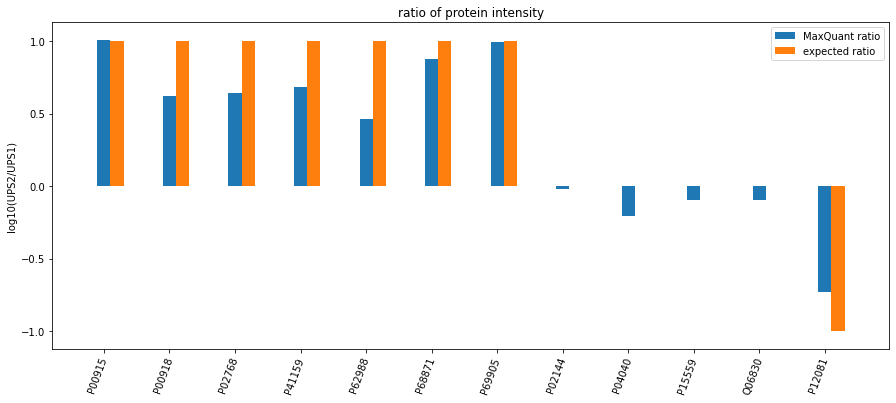

In [51]:
labels = ratios_df.protein_code
mq_ratio = np.log10(ratios_df.ratio)
expected_ratio = np.log10(ratios_df.expected_ratio)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

f, ax = plt.subplots()
f.set_figheight(6)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

rects1 = ax.bar(x, mq_ratio, width, label='MaxQuant ratio')
rects2 = ax.bar(x + width, expected_ratio, width, label='expected ratio')

# add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('log10(UPS2/UPS1)')
ax.set_title('ratio of protein intensity')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=70, ha='right')
ax.legend()

# create offset transform (x=5pt)
from matplotlib.transforms import ScaledTranslation
dx, dy = 5, 0
offset = ScaledTranslation(dx/f.dpi, dy/f.dpi, scale_trans=f.dpi_scale_trans)

# apply offset transform to all xticklabels
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
plt.show()

### how many proteins does MaxQuant find with Andromeda

In [52]:
MQ_ANALYSIS_DIR = '{}/MQ-analysis-of-P3830/combined/txt'.format(expanduser('~'))

In [53]:
mq_results_df = pd.read_csv('{}/evidence.txt'.format(MQ_ANALYSIS_DIR), sep='\\t', engine='python')

In [54]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]
# remove yeast proteins
mq_results_df = mq_results_df[(~mq_results_df['Proteins'].str.contains('YEAST'))]


In [55]:
mq_results_df.sample(n=10)[['Proteins','Leading proteins']]

,Proteins,Leading proteins
14403,sp|P02787|TRFE_HUMAN,sp|P02787|TRFE_HUMAN
94668,sp|P00918|CAH2_HUMAN,sp|P00918|CAH2_HUMAN
61432,sp|P12081|HARS1_HUMAN,sp|P12081|HARS1_HUMAN
96356,sp|P02753|RET4_HUMAN,sp|P02753|RET4_HUMAN
56121,sp|P68871|HBB_HUMAN,sp|P68871|HBB_HUMAN
8948,sp|Q14674|ESPL1_HUMAN,sp|Q14674|ESPL1_HUMAN
22312,sp|P04040|CATA_HUMAN,sp|P04040|CATA_HUMAN
128888,sp|P00918|CAH2_HUMAN,sp|P00918|CAH2_HUMAN
105241,sp|P41159|LEP_HUMAN,sp|P41159|LEP_HUMAN
65775,sp|P00441|SODC_HUMAN,sp|P00441|SODC_HUMAN


In [56]:
# definition of uniqueness in MaxQuant output with MBR on
proteins_l = []
unique_peptide_key = ['Sequence','Modifications','Charge']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key):
    protein = group_df.iloc[0]['Leading proteins']
    if len(group_df['Leading proteins'].unique()) > 1:
        print('more than one protein')
    proteins_l.append({'peptide':group_name, 'protein':protein})
mq_proteins_df = pd.DataFrame(proteins_l)

In [57]:
print('number of unique proteins: {}'.format(len(mq_proteins_df.protein.unique())))

number of unique proteins: 85
